In [1]:
###
###  Import packages
###

import os
import imageio
import numpy as np
from matplotlib import lines as mlines, patches as mpatches, pyplot as plt
from scipy import stats


In [2]:
###
###  Configure MLP
###
#
# Start at state (d,h) = (0,0)
# Available actions are right, up-right, down-right which iterate state by (1,0), (1,1), (1,-1) respectively
# Do not pass into h<0 or h>max_h, penalty of +1 applied for trying
# When reach distance of d=max_d, game terminates if state is d=15 with reward of r=+100 if h>0
# No infinite horizon problem, so discount_factor=1
# Reward for "right" action is r=max_h+1-h, so upper elevations encouraged, but rewards still positive
# Reward for "upper right" action is r=-old_h+climb_penalty
# Reward for "upper left" action is r=-old_h+descent_penalty

max_d           = 13
max_h           = 5
climb_penalty   = 2
descent_penalty = -.5   # descending is slightly easier than staying level


In [3]:
###
###  Define some utility methods we will need before creating plot functions
### 

def summarise_method(method) :
    '''
    Print a message summarising a method by calling its help() string
    Input:
       - method: python method
                 object to call help(method) on
    '''
    print("-"*28 + "\n-----  DEFINED METHOD  -----\n" + "-"*28)
    help(method)
    
summarise_method(summarise_method)

def generate_directory_for_file_path(fname, print_msg_on_dir_creation=True) :
    """
    Create the directory structure needed to place file fname. Call this before fig.savefig(fname, ...) to 
    make sure fname can be created without a FileNotFoundError
    Input:
       - fname: str
                name of file you want to create a tree of directories to enclose
                also create directory at this path if fname ends in '/'
       - print_msg_on_dir_creation: bool, default = True
                                    if True then print a message whenever a new directory is created
    """
    while "//" in fname :
        fname = fname.replace("//", "/")
    dir_tree = fname.split("/")
    dir_tree = ["/".join(dir_tree[:i]) for i in range(1,len(dir_tree))]
    dir_path = ""
    for dir_path in dir_tree :
        if len(dir_path) == 0 : continue
        if not os.path.exists(dir_path) :
            os.mkdir(dir_path)
            if print_msg_on_dir_creation :
                print(f"Directory {dir_path} created")
            continue
        if os.path.isdir(dir_path) : 
            continue
        raise RuntimeError(f"Cannot create directory {dir_path} because it already exists and is not a directory")
    
summarise_method(generate_directory_for_file_path)



----------------------------
-----  DEFINED METHOD  -----
----------------------------
Help on function summarise_method in module __main__:

summarise_method(method)
    Print a message summarising a method by calling its help() string
    Input:
       - method: python method
                 object to call help(method) on

----------------------------
-----  DEFINED METHOD  -----
----------------------------
Help on function generate_directory_for_file_path in module __main__:

generate_directory_for_file_path(fname, print_msg_on_dir_creation=True)
    Create the directory structure needed to place file fname. Call this before fig.savefig(fname, ...) to 
    make sure fname can be created without a FileNotFoundError
    Input:
       - fname: str
                name of file you want to create a tree of directories to enclose
                also create directory at this path if fname ends in '/'
       - print_msg_on_dir_creation: bool, default = True
                              

In [4]:
###
###  Define a function for creating axes containing the game board
### 

def create_game_board_figure() :
    '''
    Return a matplotlib figure and axis containing a pre-drawn game board
    Output:
       - fig, matplotlib Figure object
       - ax, matplotlib Axis object associated with fig
    '''
    fig = plt.figure(figsize=(1*max_d, 1*max_h))
    ax  = fig.add_subplot(1, 1, 1)
    ax.tick_params(right=True, top=True, labelsize=14, direction="in")
    ax.set_xlim(-0.5, max_d+0.5)
    ax.set_ylim(-0.5, max_h+0.5)
    for i in range(max_d) :
        ax.axvline(i+0.5, c="gray", lw=0.6, ls=":")
    for i in range(max_h) :
        ax.axhline(i+0.5, c="gray", lw=0.6, ls=":")
    ax.fill_between([     -.5,       .5], -.5, .5, color="lightgray", alpha=0.7)
    ax.fill_between([max_d-.5, max_d+.5], -.5, .5, color="lightgray", alpha=0.7)
    ax.fill_between([max_d-.5, max_d+.5], .5, max_h+.5, color="lightgray", alpha=0.3)
    ax.set_xlabel("horizontal distance, $d$", fontsize=17, labelpad=20)
    ax.set_ylabel("altitude, $h$", fontsize=17, labelpad=20, ha="right", rotation=0)
    return fig, ax


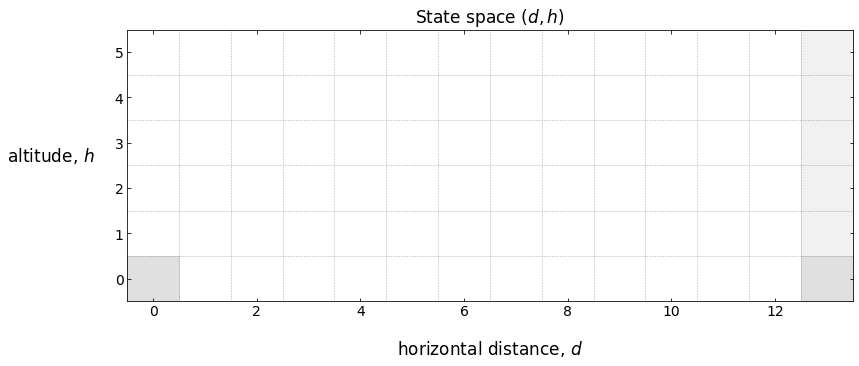

In [5]:
###
###  Draw game board
### 
    
fig, ax = create_game_board_figure()
ax.set_title("State space $(d,h)$", fontsize=17, pad=7)
plt.show(fig)

In [6]:
###
###  Define dynamic programming methods, and other utility methods
### 

def get_greedy_policy(vfe, discount_factor=1.) :
    '''
    Return the greedy policy associated with a given value function estimate vfe
    Inputs:
       - vfe : NxN numpy array
               matrix of value function estimates
       - discount_factor : float, default = 1.
                           discount factor
    '''
    assert vfe.shape == (max_d+1, max_h+1)
    policy = np.zeros(shape=(max_d+1, max_h+1, 3))
    for d in range(vfe.shape[0]) :
        for h in range(vfe.shape[1]) :
            if not is_possible_state((d,h)) : continue
            best_a, best_v = [], np.inf
            for a in range(3) :
                sp, r = get_state_and_reward_after_action((d,h), a)
                v = r if is_terminal_state(sp) else r + discount_factor * vfe[sp[0], sp[1]]
                if v > best_v : continue
                if v == best_v :
                    best_a += [a]
                    continue
                best_a = [a]
                best_v = v
            for a in best_a :
                policy[d, h, a] = 1. / len(best_a)
    return policy

summarise_method(get_greedy_policy)


def get_initial_vfe(rogue=np.nan) :
    '''
    Return a value function estimate matrix with elements set to 0 if a state is possible and rogue otherwise
    Input:
       - rogue : float, default = np.nan
                 initial vfe matrix for all matrix elements corresponding to impossible-states
    '''
    vfe = np.zeros(shape=(max_d+1, max_h+1))
    for d in range(vfe.shape[0]) :
        for h in range(vfe.shape[1]) :
            if is_possible_state((d,h)) : continue
            vfe[d, h] = np.nan
    return vfe

summarise_method(get_initial_vfe)


def get_state_and_reward_after_action(s, a) :
    '''
    Return new state and reward emitted for action a taken in state s
    Input:
       - s  : (d,h) state value
       - a  : {0,1,2} for action {UR,R,DR} respectively
    Output:
       - s' : new (d,h) state value 
       - r  : reward value, float
    '''
    assert a in [0, 1, 2], f"Action a must be integer in [UR=0, R=1, DR=2] but type {type(a)} value {a} provided"
    old_d, old_h = s
    new_d, new_h = old_d + 1, old_h
    r = max_h + 1 - float(old_h)
    if a == 0 : 
        if old_h == max_h :
            r += 1
        else :
            new_h += 1
            r += climb_penalty
    if a == 2 : 
        if old_h == 0 :
            r += 1
        else :
            new_h -= 1
            r += descent_penalty
    if new_d == max_d and new_h > 0 :
        r += 100.
    return (new_d, new_h), r

summarise_method(get_state_and_reward_after_action)


def is_terminal_state(s) :
    '''
    Return True if s is a terminal state
    Input:
       - s  : (d,h) state value
    Output:
       - bool : True if s is terminal state, False otherwise
    '''
    return s[0] == max_d

summarise_method(is_terminal_state)


def is_possible_state(s) :
    '''
    Return True if s is a state which it is possible to access
    Input:
       - s  : (d,h) state value
    Output:
       - bool : True if s is possible state, False otherwise
    '''
    d, h = s
    return (d - h >= 0) and (not is_terminal_state(s))

summarise_method(is_possible_state)

    
def iterate_vfe(old_vfe, policy, discount_factor=1) :
    '''
    Return new value function estimate after one interation
    Input:
       - old_vfe : 2D-array of shape (max_d+1, max_h+1)
                   old value function estimate
       - policy  : 3D-array of shape (max_d+1, max_h+1, 3)
                   probability of taking action [UR=0,R=1,LR=2] in each state
       - discount_factor : float, default = 1.
                           discount factor to apply
    Output:
       - new_vfe : 2D-array of shape (max_d+1, max_h+1)
                   new value function estimate
    '''
    assert old_vfe.shape == (max_d+1, max_h+1)
    new_vfe = old_vfe.copy()
    for d in range(old_vfe.shape[0]) :
        for h in range(old_vfe.shape[1]) :
            if is_terminal_state((d,h)) : continue
            if not is_possible_state((d,h)) : continue
            vfe_dh = 0.
            for a, prob_a in enumerate(policy[d,h]) :
                sp, r = get_state_and_reward_after_action((d,h), a)
                vfe_dh += prob_a * r 
                if is_terminal_state(sp) : continue
                vfe_dh += prob_a * discount_factor * old_vfe[sp[0], sp[1]]
            new_vfe[d,h] = vfe_dh   
    return new_vfe

summarise_method(iterate_vfe)


----------------------------
-----  DEFINED METHOD  -----
----------------------------
Help on function get_greedy_policy in module __main__:

get_greedy_policy(vfe, discount_factor=1.0)
    Return the greedy policy associated with a given value function estimate vfe
    Inputs:
       - vfe : NxN numpy array
               matrix of value function estimates
       - discount_factor : float, default = 1.
                           discount factor

----------------------------
-----  DEFINED METHOD  -----
----------------------------
Help on function get_initial_vfe in module __main__:

get_initial_vfe(rogue=nan)
    Return a value function estimate matrix with elements set to 0 if a state is possible and rogue otherwise
    Input:
       - rogue : float, default = np.nan
                 initial vfe matrix for all matrix elements corresponding to impossible-states

----------------------------
-----  DEFINED METHOD  -----
----------------------------
Help on function get_state_and_rewa

In [7]:
###
###  Define method for visualising value function estimates and associated policies
### 

def plot_vfe_and_policy(vfe, policy, title="", policy_label="policy", lc="red", max_width=0.1, arrowalpha=0.4,
                        dpi=200, show=False, savefile="") :
    '''
    Create a plot of the value function estimate and policy provided
    Input:
       - vfe: NxN np.ndarray
              matrix of value function estimates
       - policy: NxNx3 np.ndarray
                 tensor of prob(action|state)
       - title: str, default ''
                title to be written on the plot if provided
       - policy_label: str, default = 'policy'
                       legend label assigned to the policy line
       - lc: str, default = 'red'
             linecolor
       - max_width: float, default = 0.1
                    maximum arrow width
       - arrowalpha: float, default = 0.6
                    aplha assigned to the policy arrows
       - dpi: int, default=200
              pixels/inch for png plot
       - show: bool, default False
               if True then call plt.show(fig) on the figure
       - savefile: str, default = ''
                   filename to save the plot to if provided (directory is created if needed)
    Output:
       - fig: matplotlib Figure object
              figure created
       - ax: matplotlib AxesSubplot object
             axes created
    '''
    fig, ax = create_game_board_figure()
    for d in range(vfe.shape[0]) :
        for h in range(vfe.shape[1]) :
            if not is_possible_state((d,h)) : continue
            for a in range(3) :
                prob_a = policy[d, h, a]
                if prob_a == 0 : continue
                sp, r  = get_state_and_reward_after_action((d,h), a)
                #ax.plot([d, sp[0]], [h, sp[1]], "-", lw=max_lw*prob_a, c=lc, alpha=linealpha)
                centre_square1 = np.array([d, h])
                centre_square2 = np.array(sp)
                delta_square   = centre_square2 - centre_square1
                a_start, a_end = centre_square1 + 0.15*delta_square, centre_square2 - 0.15*delta_square
                delta_a        = a_end - a_start
                ax.arrow(a_start[0], a_start[1], delta_a[0], delta_a[1], width=max_width*prob_a, color=lc, 
                         alpha=arrowalpha, length_includes_head=True, head_width=4*max_width*prob_a, 
                         head_length=0.2*np.sqrt(delta_a[0]**2 + delta_a[0]**2))
            ax.text(d, h, f"{vfe[d, h]:.1f}", ha="center", va="center", fontsize=15)
    if len(title) > 0 : 
        ax.set_title(title, fontsize=17, pad=10, loc="right")
    if len(policy_label) > 0 :
        ax.legend([mlines.Line2D([], [], lw=3, c=lc, alpha=0.6, marker=">", ms=12)], [policy_label], 
                  loc=(0,1), fontsize=17, frameon=False)
    if show :
        plt.show(fig)
    if len(savefile) > 0 :
        generate_directory_for_file_path(savefile)
        fig.savefig(savefile, bbox_inches="tight", dpi=dpi)
        print(f"Figure saved to file {savefile}")
    return fig, ax
    
summarise_method(plot_vfe_and_policy)

----------------------------
-----  DEFINED METHOD  -----
----------------------------
Help on function plot_vfe_and_policy in module __main__:

plot_vfe_and_policy(vfe, policy, title='', policy_label='policy', lc='red', max_width=0.1, arrowalpha=0.4, dpi=200, show=False, savefile='')
    Create a plot of the value function estimate and policy provided
    Input:
       - vfe: NxN np.ndarray
              matrix of value function estimates
       - policy: NxNx3 np.ndarray
                 tensor of prob(action|state)
       - title: str, default ''
                title to be written on the plot if provided
       - policy_label: str, default = 'policy'
                       legend label assigned to the policy line
       - lc: str, default = 'red'
             linecolor
       - max_width: float, default = 0.1
                    maximum arrow width
       - arrowalpha: float, default = 0.6
                    aplha assigned to the policy arrows
       - dpi: int, default=200
      

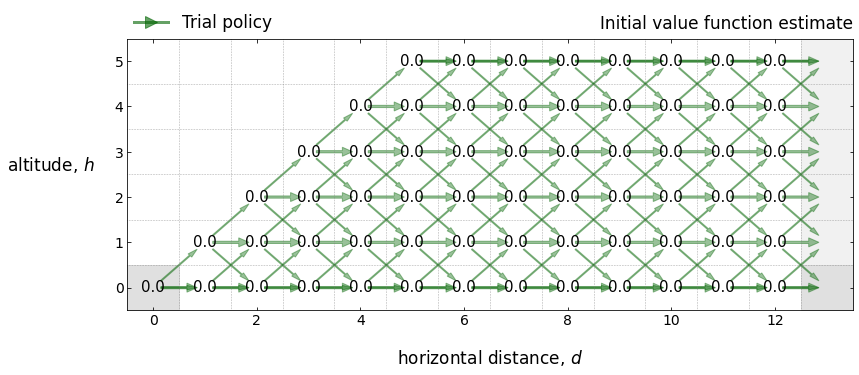

Figure saved to file figures/Simple_flight_dynamic_programming/initial_trial_policy.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr1.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr2.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr3.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr4.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr5.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr6.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr7.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr8.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr9.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr10.png
Figure save

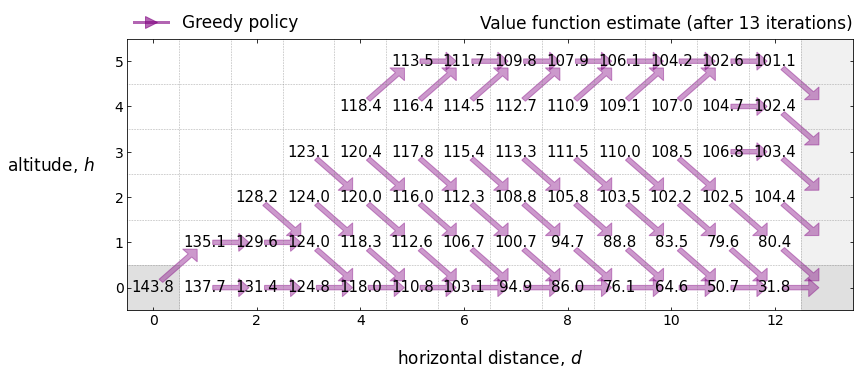

Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_complete.png
Policy evaluation complete


In [8]:
###
### Perform iterative policy evaluation on some trial policy
###

#  Set trial policy of shape (max_d+1, max_h+1, 3)
#    policy is multinomial probability distribution over (UR, R, LR) for each state
policy = np.full(shape=(max_d+1, max_h+1, 3), fill_value = (0.25, 0.5, 0.25))

#  Set number of iterations
num_itr_eval = max_d

#  Initialise value function estimate (vfe), and plot this alongside the trial policy
vfe    = get_initial_vfe()
plot_vfe_and_policy(vfe, policy, "Initial value function estimate", "Trial policy", lc="darkgreen", 
                    savefile="figures/Simple_flight_dynamic_programming/initial_trial_policy.png", show=True)

#  Iteration vfe estimate once, and plot the new vfe alonside its corresponding greedy policy
vfe           = iterate_vfe(vfe, policy)
greedy_policy = get_greedy_policy(vfe)
plot_vfe_and_policy(vfe, greedy_policy, "Value function estimate (after 1 iteration)", "Greedy policy", lc="purple",
                    savefile="figures/Simple_flight_dynamic_programming/policy_evaluation_itr1.png")

#  Iteration vfe estimate once more, and plot the new vfe alonside its corresponding greedy policy
vfe           = iterate_vfe(vfe, policy)
greedy_policy = get_greedy_policy(vfe)
plot_vfe_and_policy(vfe, greedy_policy, "Value function estimate (after 2 iterations)", "Greedy policy", lc="purple",
                    savefile="figures/Simple_flight_dynamic_programming/policy_evaluation_itr2.png")

#  Complete the number of vfe iterations specified by num_itr (number includes the two already done)
#     and plot vfe and greedy policy at every stage
for itr_idx in range(num_itr_eval-2) :
    vfe = iterate_vfe(vfe, policy)
    greedy_policy = get_greedy_policy(vfe)
    plot_vfe_and_policy(vfe, greedy_policy, f"Value function estimate (after {3+itr_idx} iterations)", "Greedy policy", lc="purple",
                        savefile=f"figures/Simple_flight_dynamic_programming/policy_evaluation_itr{3+itr_idx}.png")

#  Close all intermediate figures to prevent them being shown by matplotlib running in inline mode
plt.close('all')

#  Plot the final vfe alonside its corresponding greedy policy
plot_vfe_and_policy(vfe, greedy_policy, f"Value function estimate (after {num_itr_eval} iterations)", "Greedy policy", lc="purple",
                    savefile="figures/Simple_flight_dynamic_programming/policy_evaluation_complete.png", show=True)
    
print("Policy evaluation complete")

In [9]:
#  Create animated plot of iterative policy evaluation

fnames = ["figures/Simple_flight_dynamic_programming/initial_trial_policy.png"] + [f"figures/Simple_flight_dynamic_programming/policy_evaluation_itr{i+1}.png" for i in range(0,num_itr_eval)]
imageio.mimsave('figures/Simple_flight_dynamic_programming/policy_evaluation_animated.gif', 
                [imageio.v2.imread(fname) for fname in fnames], fps=.6)


![SegmentLocal](figures/Simple_flight_dynamic_programming/policy_evaluation_animated.gif "segment")

Figure saved to file figures/Simple_flight_dynamic_programming/policy_iteration_itr1.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_iteration_itr2.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_iteration_itr3.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_iteration_itr4.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_iteration_itr5.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_iteration_itr6.png


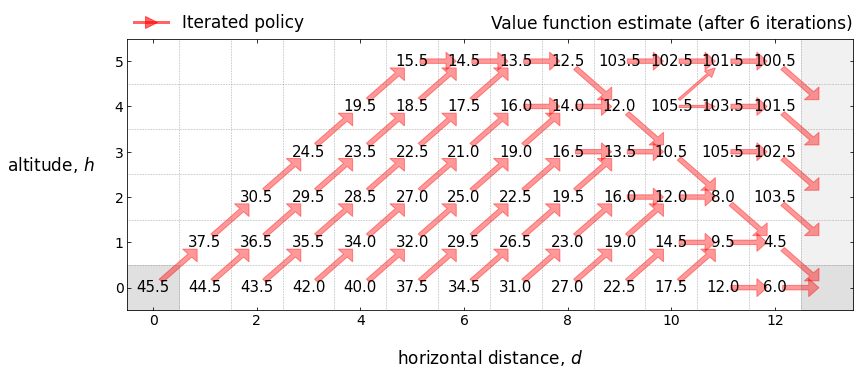

Figure saved to file figures/Simple_flight_dynamic_programming/policy_iteration_complete.png
Policy iteration complete


In [10]:
###
### Perform policy iteration on some trial policy
###

#  Create new policy and vfe objects to iterate
iterated_policy = policy.copy()
vfe             = get_initial_vfe()

#  Tracking variables
delta_policy = 1   # equals sum_ijk { |current_policy_ijk - last_policy_ijk| }
policy_itr   = 0   # number of policy iterations completed

#  Perform policy iteration
while delta_policy > 0 :
    for itr_idx in range(num_itr_eval) :
        vfe = iterate_vfe(vfe, iterated_policy)
    greedy_policy   = get_greedy_policy(vfe)
    delta_policy    = np.fabs(greedy_policy.flatten() - iterated_policy.flatten()).sum()
    iterated_policy = greedy_policy
    policy_itr += 1
    plot_vfe_and_policy(vfe, iterated_policy, f"Value function estimate (after {policy_itr} policy iterations)", "Iterated policy", lc="red",
                        savefile=f"figures/Simple_flight_dynamic_programming/policy_iteration_itr{policy_itr}.png")
    
#  Close all intermediate figures to prevent them being shown by matplotlib running in inline mode
plt.close('all')

#  Plot the final vfe alonside its corresponding greedy policy
plot_vfe_and_policy(vfe, greedy_policy, f"Value function estimate (after {policy_itr} iterations)", "Iterated policy", lc="red",
                    savefile="figures/Simple_flight_dynamic_programming/policy_iteration_complete.png", show=True)

print("Policy iteration complete")

In [11]:
#  Create animated plot of policy iteration

fnames = ["figures/Simple_flight_dynamic_programming/initial_trial_policy.png"] + [f"figures/Simple_flight_dynamic_programming/policy_iteration_itr{i+1}.png" for i in range(0,policy_itr)]
imageio.mimsave('figures/Simple_flight_dynamic_programming/policy_iteration_animated.gif', 
                [imageio.v2.imread(fname) for fname in fnames], fps=.6)


![SegmentLocal](figures/Simple_flight_dynamic_programming/policy_iteration_animated.gif "segment")

Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr1.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr2.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr3.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr4.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr5.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr6.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr7.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr8.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr9.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr10.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr11.png
Figure saved to file figures/S

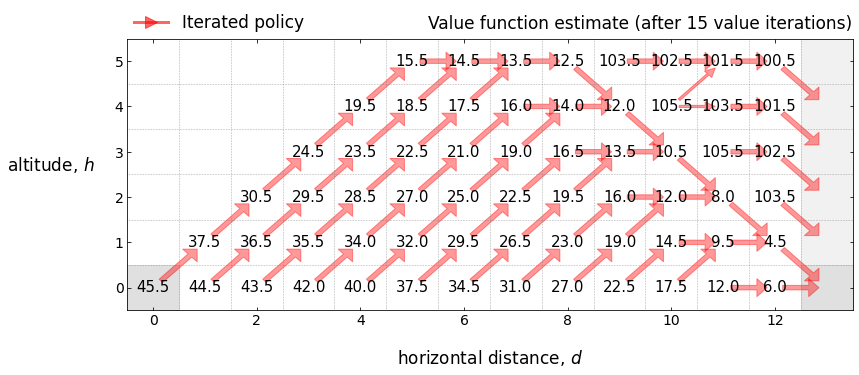

Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_complete.png
Value iteration complete


In [12]:
###
### Perform value iteration on some trial policy
###

#  Create new policy and vfe objects to iterate
iterated_policy = policy.copy()
vfe             = get_initial_vfe()

#  Tracking variables
delta_vfe = 1   # equals sum_ij { |current_vfe_ij - last_vfe_ij| }
value_itr = 0   # number of policy iterations completed

#  Perform value iteration
while delta_vfe > .1 :
    new_vfe         = iterate_vfe(vfe, iterated_policy)
    delta_vfe       = np.fabs(np.where(np.isfinite(new_vfe), new_vfe - vfe, 0.)).sum()
    vfe             = new_vfe
    iterated_policy = get_greedy_policy(vfe)
    value_itr += 1
    plot_vfe_and_policy(vfe, iterated_policy, f"Value function estimate (after {value_itr} value iterations)", "Iterated policy", lc="red",
                        savefile=f"figures/Simple_flight_dynamic_programming/value_iteration_itr{value_itr}.png")

#  Close all intermediate figures to prevent them being shown by matplotlib running in inline mode
plt.close('all')

#  Plot the final vfe alongside the final policy
plot_vfe_and_policy(vfe, iterated_policy, f"Value function estimate (after {value_itr} value iterations)", "Iterated policy", lc="red",
                    savefile="figures/Simple_flight_dynamic_programming/value_iteration_complete.png", show=True)
    
print("Value iteration complete")

In [13]:
#  Create animated plot of value interation

fnames = ["figures/Simple_flight_dynamic_programming/initial_trial_policy.png"] + [f"figures/Simple_flight_dynamic_programming/value_iteration_itr{i+1}.png" for i in range(0,value_itr)]
imageio.mimsave('figures/Simple_flight_dynamic_programming/value_iteration_animated.gif', 
                [imageio.v2.imread(fname) for fname in fnames], fps=.6)


![SegmentLocal](figures/Simple_flight_dynamic_programming/value_iteration_animated.gif "segment")

## 2. Alternate flight paths

In [14]:
###
###  Define dynamic programming methods, and other utility methods
### 

def get_greedy_policy_alt(vfe, discount_factor=1.) :
    '''
    Return the greedy policy associated with a given value function estimate vfe
    Inputs:
       - vfe : NxN numpy array
               matrix of value function estimates
       - discount_factor : float, default = 1.
                           discount factor
    '''
    assert vfe.shape == (max_d+1, max_h+1)
    policy = np.zeros(shape=(max_d+1, max_h+1, 6))
    for d in range(vfe.shape[0]) :
        for h in range(vfe.shape[1]) :
            if not is_possible_state_alt((d,h)) : continue
            best_a, best_v = [], np.inf
            for a in range(6) :
                sp, r = get_state_and_reward_after_action_alt((d,h), a)
                v = r if is_terminal_state(sp) else r + discount_factor * vfe[sp[0], sp[1]]
                if v > best_v : continue
                if v == best_v :
                    best_a.append(a)
                    continue
                best_a = [a]
                best_v = v
            for a in best_a :
                policy[d, h, a] = 1. / len(best_a)
    return policy

summarise_method(get_greedy_policy_alt)


def get_initial_vfe_alt(rogue=np.nan) :
    '''
    Return a value function estimate matrix with elements set to 0 if a state is possible and rogue otherwise
    Input:
       - rogue : float, default = np.nan
                 initial vfe matrix for all matrix elements corresponding to impossible-states
    '''
    vfe = np.zeros(shape=(max_d+1, max_h+1))
    return vfe

summarise_method(get_initial_vfe_alt)


def get_state_and_reward_after_action_alt(s, a) :
    '''
    Return new state and reward emitted for action a taken in state s
    Input:
       - s  : (d,h) state value
       - a  : {0,1,2,3,4,5} for action {UR,R,DR,DL,L,UL} respectively
    Output:
       - s' : new (d,h) state value 
       - r  : reward value, float
    '''
    assert a in [0, 1, 2, 3, 4, 5], f"Action a must be integer in [UR=0, R=1, DR=2, DL=3, L=4, UL=5] but type {type(a)} value {a} provided"
    old_d, old_h = s
    new_d, new_h = old_d + 1 if a < 2.5 else old_d - 1, old_h
    r = max_h + 1 - old_h
    if new_d < 0 :
        r += 1
        new_d = 0
    else :
        if a in [0, 5] : 
            if old_h == max_h :
                r += 1
            else :
                new_h += 1
                r     += climb_penalty
        if a in [2, 3] : 
            if old_h == 0 :
                r += 1
            else :
                new_h -= 1
                r     += descent_penalty
    if new_d == max_d and new_h > 0 :
        r += 100
    return (new_d, new_h), r

summarise_method(get_state_and_reward_after_action_alt)


def is_possible_state_alt(s) :
    '''
    Return True if s is a state which it is possible to access
    Input:
       - s  : (d,h) state value
    Output:
       - bool : True if s is possible state, False otherwise
    '''
    return not is_terminal_state(s)

summarise_method(is_possible_state_alt)

    
def iterate_vfe_alt(old_vfe, policy, discount_factor=1) :
    '''
    Return new value function estimate after one interation
    Input:
       - old_vfe : 2D-array of shape (max_d+1, max_h+1)
                   old value function estimate
       - policy  : 3D-array of shape (max_d+1, max_h+1, 3)
                   probability of taking action [UR=0,R=1,LR=2] in each state
       - discount_factor : float, default = 1.
                           discount factor to apply
    Output:
       - new_vfe : 2D-array of shape (max_d+1, max_h+1)
                   new value function estimate
    '''
    assert old_vfe.shape == (max_d+1, max_h+1)
    new_vfe = old_vfe.copy()
    for d in range(old_vfe.shape[0]) :
        for h in range(old_vfe.shape[1]) :
            if is_terminal_state((d,h)) : continue
            vfe_dh = 0.
            for a, prob_a in enumerate(policy[d,h]) :
                sp, r = get_state_and_reward_after_action_alt((d,h), a)
                vfe_dh += prob_a * r 
                if is_terminal_state(sp) : continue
                vfe_dh += prob_a * discount_factor * old_vfe[sp[0], sp[1]]
            new_vfe[d,h] = vfe_dh   
    return new_vfe

summarise_method(iterate_vfe_alt)


----------------------------
-----  DEFINED METHOD  -----
----------------------------
Help on function get_greedy_policy_alt in module __main__:

get_greedy_policy_alt(vfe, discount_factor=1.0)
    Return the greedy policy associated with a given value function estimate vfe
    Inputs:
       - vfe : NxN numpy array
               matrix of value function estimates
       - discount_factor : float, default = 1.
                           discount factor

----------------------------
-----  DEFINED METHOD  -----
----------------------------
Help on function get_initial_vfe_alt in module __main__:

get_initial_vfe_alt(rogue=nan)
    Return a value function estimate matrix with elements set to 0 if a state is possible and rogue otherwise
    Input:
       - rogue : float, default = np.nan
                 initial vfe matrix for all matrix elements corresponding to impossible-states

----------------------------
-----  DEFINED METHOD  -----
----------------------------
Help on function ge

In [15]:
###
###  Define method for visualising value function estimates and associated policies
### 

def plot_vfe_and_policy_alt(vfe, policy, title="", policy_label="policy", lc="red", max_width=0.1, linealpha=0.2,
                            dpi=200, show=False, savefile="") :
    '''
    Create a plot of the value function estimate and policy provided
    Input:
       - vfe: NxN np.ndarray
              matrix of value function estimates
       - policy: NxNx3 np.ndarray
                 tensor of prob(action|state)
       - title: str, default ''
                title to be written on the plot if provided
       - policy_label: str, default = 'policy'
                       legend label assigned to the policy line
       - lc: str, default = 'red'
             linecolor
       - max_width: float, default = 2.
                    maximum linewidth
       - linealpha: float, default = 0.6
                    aplha assigned to the policy lines
       - dpi: int, default=200
              pixels/inch for png plot
       - show: bool, default False
               if True then call plt.show(fig) on the figure
       - savefile: str, default = ''
                   filename to save the plot to if provided (directory is created if needed)
    Output:
       - fig: matplotlib Figure object
              figure created
       - ax: matplotlib AxesSubplot object
             axes created
    '''
    fig, ax = create_game_board_figure()
    for d in range(vfe.shape[0]) :
        for h in range(vfe.shape[1]) :
            if is_terminal_state((d,h)) : continue
            for a in range(6) :
                prob_a = policy[d, h, a]
                if prob_a == 0 : continue
                sp, r  = get_state_and_reward_after_action_alt((d,h), a)
                centre_square1 = np.array([d, h])
                centre_square2 = np.array(sp)
                delta_square   = centre_square2 - centre_square1
                a_start, a_end = centre_square1 + 0.15*delta_square, centre_square2 - 0.15*delta_square
                delta_a        = a_end - a_start
                ax.arrow(a_start[0], a_start[1], delta_a[0], delta_a[1], width=max_width*prob_a, color=lc, 
                         alpha=linealpha, length_includes_head=True, head_width=4*max_width*prob_a, 
                         head_length=0.2*np.sqrt(delta_a[0]**2 + delta_a[0]**2))
            ax.text(d, h, f"{vfe[d, h]:.1f}", ha="center", va="center", fontsize=15)
    if len(title) > 0 : 
        ax.set_title(title, fontsize=17, pad=10, loc="right")
    if len(policy_label) > 0 :
        ax.legend([mlines.Line2D([], [], lw=3, c=lc, marker='>', alpha=0.6, ms=12)], [policy_label], 
                  loc=(0,1), fontsize=17, frameon=False)
    if show :
        plt.show(fig)
    if len(savefile) > 0 :
        generate_directory_for_file_path(savefile)
        fig.savefig(savefile, bbox_inches="tight", dpi=dpi)
        print(f"Figure saved to file {savefile}")
    return fig, ax
    
summarise_method(plot_vfe_and_policy_alt)

----------------------------
-----  DEFINED METHOD  -----
----------------------------
Help on function plot_vfe_and_policy_alt in module __main__:

plot_vfe_and_policy_alt(vfe, policy, title='', policy_label='policy', lc='red', max_width=0.1, linealpha=0.2, dpi=200, show=False, savefile='')
    Create a plot of the value function estimate and policy provided
    Input:
       - vfe: NxN np.ndarray
              matrix of value function estimates
       - policy: NxNx3 np.ndarray
                 tensor of prob(action|state)
       - title: str, default ''
                title to be written on the plot if provided
       - policy_label: str, default = 'policy'
                       legend label assigned to the policy line
       - lc: str, default = 'red'
             linecolor
       - max_width: float, default = 2.
                    maximum linewidth
       - linealpha: float, default = 0.6
                    aplha assigned to the policy lines
       - dpi: int, default=200
    

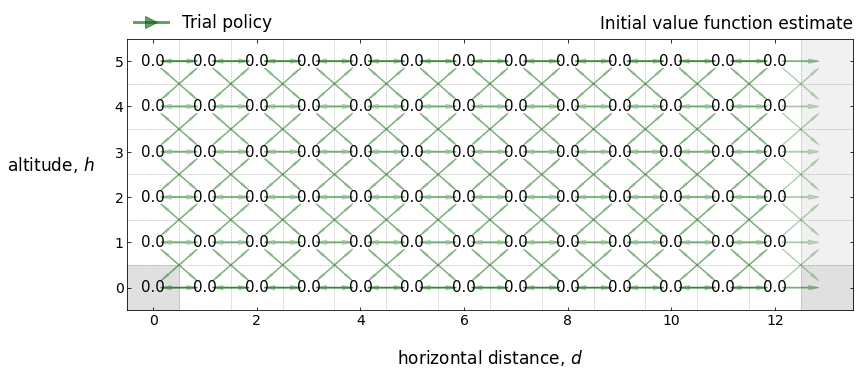

Figure saved to file figures/Simple_flight_dynamic_programming/initial_trial_policy_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr1_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr2_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr3_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr4_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr5_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr6_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr7_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr8_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_itr9_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming

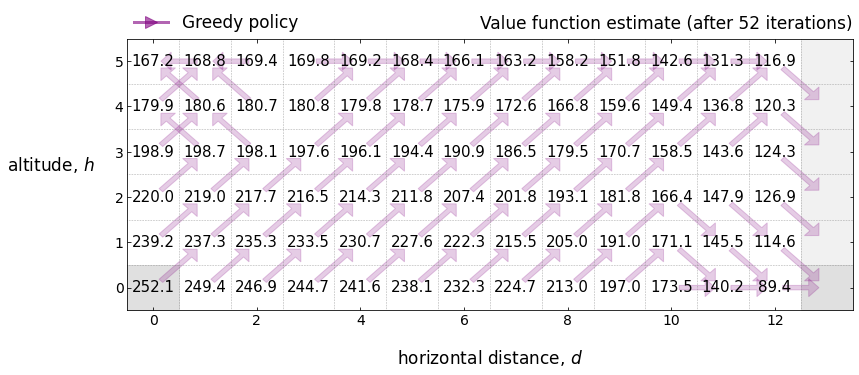

Figure saved to file figures/Simple_flight_dynamic_programming/policy_evaluation_complete_alt.png
Policy evaluation complete


In [16]:
###
### Perform iterative policy evaluation on some trial policy
###

#  Set trial policy of shape (max_d+1, max_h+1, 3)
#    policy is multinomial probability distribution over (UR, R, LR) for each state
policy = np.full(shape=(max_d+1, max_h+1, 6), fill_value = (0.125, 0.25, 0.125, 0.125, 0.25, 0.125))

#  Set number of iterations
num_itr_eval = 4*max_d

#  Initialise value function estimate (vfe), and plot this alongside the trial policy
vfe    = get_initial_vfe_alt()
plot_vfe_and_policy_alt(vfe, policy, "Initial value function estimate", "Trial policy", lc="darkgreen", 
                        savefile="figures/Simple_flight_dynamic_programming/initial_trial_policy_alt.png", show=True)
plt.close('all')

#  Iteration vfe estimate once, and plot the new vfe alonside its corresponding greedy policy
vfe           = iterate_vfe_alt(vfe, policy)
greedy_policy = get_greedy_policy_alt(vfe)
plot_vfe_and_policy_alt(vfe, greedy_policy, "Value function estimate (after 1 iteration)", "Greedy policy", lc="purple",
                        savefile="figures/Simple_flight_dynamic_programming/policy_evaluation_itr1_alt.png")
plt.close('all')

#  Iteration vfe estimate_alt once more, and plot the new vfe alonside its corresponding greedy policy
vfe           = iterate_vfe_alt(vfe, policy)
greedy_policy = get_greedy_policy_alt(vfe)
plot_vfe_and_policy_alt(vfe, greedy_policy, "Value function estimate (after 2 iterations)", "Greedy policy", lc="purple",
                        savefile="figures/Simple_flight_dynamic_programming/policy_evaluation_itr2_alt.png")
plt.close('all')

#  Complete the number of vfe iterations specified by num_itr (number includes the two already done)
#     and plot vfe and greedy policy at every stage
for itr_idx in range(num_itr_eval-2) :
    vfe = iterate_vfe_alt(vfe, policy)
    greedy_policy = get_greedy_policy_alt(vfe)
    plot_vfe_and_policy_alt(vfe, greedy_policy, f"Value function estimate (after {3+itr_idx} iterations)", "Greedy policy", lc="purple",
                            savefile=f"figures/Simple_flight_dynamic_programming/policy_evaluation_itr{3+itr_idx}_alt.png")
    plt.close('all')

#  Plot the final vfe alonside its corresponding greedy policy
plot_vfe_and_policy_alt(vfe, greedy_policy, f"Value function estimate (after {num_itr_eval} iterations)", "Greedy policy", lc="purple",
                        savefile="figures/Simple_flight_dynamic_programming/policy_evaluation_complete_alt.png", show=True)
    
print("Policy evaluation complete")

In [17]:
#  Create animated plot of iterative policy evaluation

fnames = ["figures/Simple_flight_dynamic_programming/initial_trial_policy_alt.png"] + [f"figures/Simple_flight_dynamic_programming/policy_evaluation_itr{i+1}_alt.png" for i in range(0,num_itr_eval)]
imageio.mimsave('figures/Simple_flight_dynamic_programming/policy_evaluation_animated_alt.gif', 
                [imageio.v2.imread(fname) for fname in fnames], fps=.6)


![SegmentLocal](figures/Simple_flight_dynamic_programming/policy_evaluation_animated_alt.gif "segment")

Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr1_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr2_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr3_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr4_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr5_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr6_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr7_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr8_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr9_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_itr10_alt.png
Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_

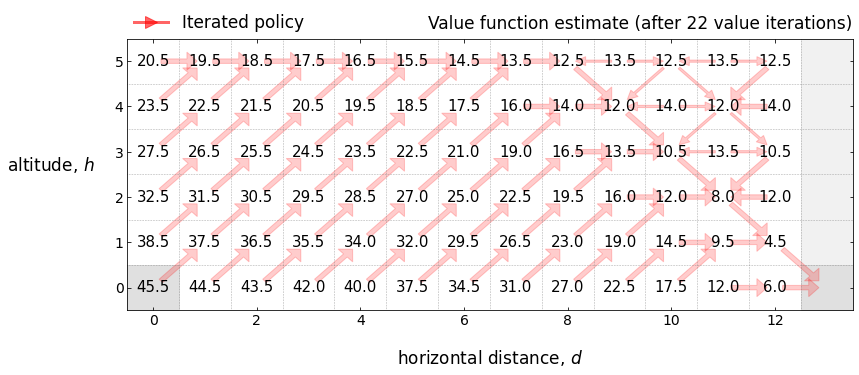

Figure saved to file figures/Simple_flight_dynamic_programming/value_iteration_complete_alt.png
Value iteration complete


In [18]:
###
### Perform value iteration on some trial policy
###

#  Create new policy and vfe objects to iterate
iterated_policy = policy.copy()
vfe             = get_initial_vfe_alt()

#  Tracking variables
delta_vfe     = 1   # equals sum_ij { |current_vfe_ij - last_vfe_ij| }
value_itr     = 0   # number of policy iterations completed
max_value_itr = 40

#  Perform value iteration
while delta_vfe > .1 and value_itr < max_value_itr :
    new_vfe         = iterate_vfe_alt(vfe, iterated_policy)
    delta_vfe       = np.fabs(np.where(np.isfinite(new_vfe), new_vfe - vfe, 0.)).sum()
    vfe             = new_vfe
    iterated_policy = get_greedy_policy_alt(vfe)
    value_itr += 1
    plot_vfe_and_policy_alt(vfe, iterated_policy, f"Value function estimate (after {value_itr} value iterations)", "Iterated policy", lc="red",
                            savefile=f"figures/Simple_flight_dynamic_programming/value_iteration_itr{value_itr}_alt.png")
    plt.close('all')

#  Close all intermediate figures to prevent them being shown by matplotlib running in inline mode
plt.close('all')

#  Plot the final vfe alongside the final policy
plot_vfe_and_policy_alt(vfe, iterated_policy, f"Value function estimate (after {value_itr} value iterations)", "Iterated policy", lc="red",
                        savefile="figures/Simple_flight_dynamic_programming/value_iteration_complete_alt.png", show=True)
plt.close('all')

print("Value iteration complete")

In [19]:
#  Create animated plot of value interation

fnames = ["figures/Simple_flight_dynamic_programming/initial_trial_policy_alt.png"] + [f"figures/Simple_flight_dynamic_programming/value_iteration_itr{i+1}_alt.png" for i in range(0,value_itr)]
imageio.mimsave('figures/Simple_flight_dynamic_programming/value_iteration_animated_alt.gif', 
                [imageio.v2.imread(fname) for fname in fnames], fps=.6)


![SegmentLocal](figures/Simple_flight_dynamic_programming/value_iteration_animated_alt.gif "segment")